# 数据建模
## 当在调试环境中运行时
使用`保险数据集-训练 `抽样数据进行训练
使用`保险数据集-c测试 `抽样数据进行测试
## 当在全量环境中运行时
使用`保险数据集-训练 `全量数据进行训练
使用`保险数据集-c测试 `全量数据进行测试

### 再使用凸优化函数optim寻找最佳的数值分割点， Quadratic_Weighted_Kappa指标值可提升4个百分点

In [1]:
#导入必要的包

#计算与可视化
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

#评估指标、编码与模型
from  sklearn.metrics import accuracy_score,  auc, confusion_matrix, roc_auc_score, classification_report,cohen_kappa_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import xgboost as xgb
from scipy.optimize import fmin_powell
#from ml_metrics import quadratic_weighted_kappa

from wf_analyse.analyse import base

# 查看数据
## 字段说明：
* Ins_Age：申请人年龄（标准化处理过的结果）
* Ht：申请人身高（标准化处理过的结果）
* Wt：申请人体重（标准化处理过的结果）
* BMI：申请人身体健康指数（标准化处理过的结果）
* Product_Info_1-7：申请产品相关的变量（处理后的结果）
* Employment_Info_1-6：有关申请人工作经验的变量（处理后的结果）
* InsuredInfo_1-6：有关申请人的信息变量（处理后的结果）
* Insurance_History_1-9：有关申请人过去的保险信息（处理后的结果）
* Family_Hist_1-5:有关申请人家庭相关的信息（处理后的结果）
* Medical_History_1-41：有关申请人的医疗史信息（处理后的结果）
* Medical_Keyword_1-48：与该保险相关或不相关的医疗信息？？？不太确定含义，该信息是伪变量
* Response：响应值（1-8级：1，2，3，4，5，6，7，8）

## 字段类型说明：
* 连续值变量：
<p> Product_Info_4, Ins_Age, Ht, Wt, BMI, Employment_Info_1, Employment_Info_4, Employment_Info_6, Insurance_History_5, Family_Hist_2, Family_Hist_3, Family_Hist_4, Family_Hist_5.<p> 

* 离散值变量：
<p> Medical_History_1, Medical_History_10, Medical_History_15, Medical_History_24, Medical_History_32
Medical_Keyword_1-48 are dummy variables.<p> 

* 无序的类别变量：
<p> Product_Info_1, Product_Info_2, Product_Info_3, Product_Info_5, Product_Info_6, Product_Info_7, Employment_Info_2, Employment_Info_3, Employment_Info_5, InsuredInfo_1, InsuredInfo_2, InsuredInfo_3, InsuredInfo_4, InsuredInfo_5, InsuredInfo_6, InsuredInfo_7, Insurance_History_1, Insurance_History_2, Insurance_History_3, Insurance_History_4, Insurance_History_7, Insurance_History_8, Insurance_History_9, Family_Hist_1, Medical_History_2, Medical_History_3, Medical_History_4, Medical_History_5, Medical_History_6, Medical_History_7, Medical_History_8, Medical_History_9, Medical_History_11, Medical_History_12, Medical_History_13, Medical_History_14, Medical_History_16, Medical_History_17, Medical_History_18, Medical_History_19, Medical_History_20, Medical_History_21, Medical_History_22, Medical_History_23, Medical_History_25, Medical_History_26, Medical_History_27, Medical_History_28, Medical_History_29, Medical_History_30, Medical_History_31, Medical_History_33, Medical_History_34, Medical_History_35, Medical_History_36, Medical_History_37, Medical_History_38, Medical_History_39, Medical_History_40, Medical_History_41

In [2]:
# 导入数据集 insurance-train-sample
 
import wfio
_INPUT = '{"type":15,"uri":"awss3175a27b5fa3d4cfcb8f037bf21c58374/sd_a27ddb1ba2fe4983ab7492e5b6a98fde"}'
 
# 读取并返回对应的Dataframe
# 参数as_spark: 为True返回Spark DataFrame，为False返回Pandas DataFrame，默认为False 
train = wfio.read_dataframe(_INPUT,as_spark = False)

In [5]:
test = train[80:]
train = train[:80]
test.head(3)

,product_info_1,product_info_2,product_info_3,product_info_4,product_info_5,product_info_6,product_info_7,ins_age,ht,wt,...,medical_keyword_40,medical_keyword_41,medical_keyword_42,medical_keyword_43,medical_keyword_44,medical_keyword_45,medical_keyword_46,medical_keyword_47,medical_keyword_48,response
80,1,A8,26,0.230769,2,3,1,0.701493,0.781818,0.322176,...,0,1,0,1,0,0,0,0,0,7
81,1,A6,10,0.230769,2,1,1,0.208955,0.727273,0.225941,...,0,0,0,0,0,0,0,0,0,7
82,1,A3,26,0.487179,2,3,1,0.358209,0.618182,0.192469,...,0,0,0,0,0,0,0,0,0,8


In [6]:
#查看训练集数据情况
print(train.info())  #"Product_Info_2是"object"类型的数据，其他字段均是数值型
print(train.columns)
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Columns: 127 entries, product_info_1 to response
dtypes: float64(18), int64(108), object(1)
memory usage: 79.5+ KB
None
Index(['product_info_1', 'product_info_2', 'product_info_3', 'product_info_4',
       'product_info_5', 'product_info_6', 'product_info_7', 'ins_age', 'ht',
       'wt',
       ...
       'medical_keyword_40', 'medical_keyword_41', 'medical_keyword_42',
       'medical_keyword_43', 'medical_keyword_44', 'medical_keyword_45',
       'medical_keyword_46', 'medical_keyword_47', 'medical_keyword_48',
       'response'],
      dtype='object', length=127)


,product_info_1,product_info_2,product_info_3,product_info_4,product_info_5,product_info_6,product_info_7,ins_age,ht,wt,...,medical_keyword_40,medical_keyword_41,medical_keyword_42,medical_keyword_43,medical_keyword_44,medical_keyword_45,medical_keyword_46,medical_keyword_47,medical_keyword_48,response
0,1,D3,26,0.364103,2,3,1,0.373134,0.781818,0.472803,...,0,0,0,0,0,0,0,0,0,5
1,1,D4,26,0.487179,2,3,1,0.298507,0.854545,0.320084,...,0,0,0,0,0,0,0,0,0,8
2,1,A8,26,0.076923,2,3,1,0.462687,0.745455,0.309623,...,0,0,0,0,0,0,0,0,0,6
3,1,D3,26,0.076923,2,3,1,0.044776,0.690909,0.184100,...,0,0,0,0,0,0,0,0,0,6
4,1,B2,29,0.487179,2,3,3,0.179104,0.818182,0.361925,...,0,0,0,0,0,0,0,0,0,8


In [7]:
#查看测试集数据情况
test.info()
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 80 to 98
Columns: 127 entries, product_info_1 to response
dtypes: float64(18), int64(108), object(1)
memory usage: 19.0+ KB


,product_info_1,product_info_2,product_info_3,product_info_4,product_info_5,product_info_6,product_info_7,ins_age,ht,wt,...,medical_keyword_40,medical_keyword_41,medical_keyword_42,medical_keyword_43,medical_keyword_44,medical_keyword_45,medical_keyword_46,medical_keyword_47,medical_keyword_48,response
80,1,A8,26,0.230769,2,3,1,0.701493,0.781818,0.322176,...,0,1,0,1,0,0,0,0,0,7
81,1,A6,10,0.230769,2,1,1,0.208955,0.727273,0.225941,...,0,0,0,0,0,0,0,0,0,7
82,1,A3,26,0.487179,2,3,1,0.358209,0.618182,0.192469,...,0,0,0,0,0,0,0,0,0,8
83,2,B2,26,0.076923,2,3,1,0.253731,0.709091,0.263598,...,0,0,0,0,0,0,0,0,0,5
84,1,C4,26,0.076923,2,1,1,0.358209,0.781818,0.489540,...,0,0,0,0,0,0,0,0,0,5


In [8]:
def eval_wrapper(yhat, y):  
    y = np.array(y)
    y = y.astype(int)
    yhat = np.array(yhat)
    yhat = np.clip(np.round(yhat), np.min(y), np.max(y)).astype(int)   
    return cohen_kappa_score(yhat, y, weights= 'quadratic')
    
    
def apply_offset(data, bin_offset, sv, scorer=eval_wrapper):
    # data has the format of pred=0, offset_pred=1, labels=2 in the first dim
    #data[0] = data[1]是预测值， data[2]是真实标签值
    #sv是是类别编号sv = 0(1, 2, 3, 4, 5, 6, 7)
    #把预测值等于sv这一类的样本预测值取出来 + bin_offset偏移量 作为新的预测值
    data[1, data[0].astype(int)==sv] = data[0, data[0].astype(int)==sv] + bin_offset
    score = scorer(data[1], data[2])
    return score

def new_target3(row):
    if (row['BMI_Wt']=='under_weight') or (row['Old_Young']=='young')  or (row['Thin_Fat']=='thin'):
        val='low_end'
    else:
        val='non_low_end'
    return val


def new_target1(row):
    if (row['BMI_Wt']=='overweight') or (row['Old_Young']=='old')  or (row['Thin_Fat']=='fat'):
        val='extremely_risky'
    else:
        val='not_extremely_risky'
    return val

def acc(y, yhat):  
    y = np.array(y)
    y = y.astype(int)
    yhat = np.array(yhat)
    yhat = np.clip(np.round(yhat), np.min(y), np.max(y)).astype(int)   
    return accuracy_score(y, yhat)

In [9]:
# 全局变量
columns_to_drop = ['response']
xgb_num_rounds = 700
num_classes = 8

In [10]:
test_label = test["response"].copy()
test["response"] = -1000
# 将训练集与测试集拼接，并于统一特征处理
all_data = train.append(test)

In [11]:
# 创建新特征 
# 特征编码
all_data['product_info_2'] = pd.factorize(all_data['product_info_2'])[0]

print('Eliminate missing values')    
# 空值填充-1
all_data.fillna(-1, inplace=True)

# 将label转为int值
all_data['response'] = all_data['response'].astype(int)

Eliminate missing values


In [12]:
# BMI离散化处理
conditions = [
    (all_data['bmi'] <= all_data['bmi'].quantile(0.25)),
    (all_data['bmi'] > all_data['bmi'].quantile(0.25)) & (all_data['bmi'] <= all_data['bmi'].quantile(0.75)),
    (all_data['bmi'] > all_data['bmi'].quantile(0.75))]

choices = ['under_weight', 'average', 'overweight']

all_data['BMI_Wt'] = np.select(conditions, choices)

# 年龄离散化处理
conditions = [
    (all_data['ins_age'] <= all_data['ins_age'].quantile(0.25)),
    (all_data['ins_age'] > all_data['ins_age'].quantile(0.25)) & (all_data['ins_age'] <= all_data['ins_age'].quantile(0.75)),
    (all_data['ins_age'] > all_data['ins_age'].quantile(0.75))]

choices = ['young', 'average', 'old']
all_data['Old_Young'] = np.select(conditions, choices)

# 身份离散化处理
conditions = [
    (all_data['ht'] <= all_data['ht'].quantile(0.25)),
    (all_data['ht'] > all_data['ht'].quantile(0.25)) & (all_data['ht'] <= all_data['ht'].quantile(0.75)),
    (all_data['ht'] > all_data['ht'].quantile(0.75))]

choices = ['short', 'average', 'tall']

all_data['Short_Tall'] = np.select(conditions, choices)

# 体重离散化处理
conditions = [
    (all_data['wt'] <= all_data['wt'].quantile(0.25)),
    (all_data['wt'] > all_data['wt'].quantile(0.25)) & (all_data['wt'] <= all_data['wt'].quantile(0.75)),
    (all_data['wt'] > all_data['wt'].quantile(0.75))]

choices = ['thin', 'average', 'fat']

all_data['Thin_Fat'] = np.select(conditions, choices)

In [13]:
##创建新特征
all_data['extreme_risk'] = all_data.apply(new_target1,axis=1)
#创建新特征
all_data['low_end_risk'] = all_data.apply(new_target3,axis=1)

In [14]:
all_data['BMI_Wt'] = pd.factorize(all_data['BMI_Wt'])[0]
all_data['Old_Young'] = pd.factorize(all_data['Old_Young'])[0]
all_data['Short_Tall'] = pd.factorize(all_data['Short_Tall'])[0]
all_data['Thin_Fat'] = pd.factorize(all_data['Thin_Fat'])[0]
all_data['extreme_risk'] = pd.factorize(all_data['extreme_risk'])[0]
all_data['low_end_risk'] = pd.factorize(all_data['low_end_risk'])[0]

In [15]:
#删除无用特征
all_data.drop(["BMI_Wt", "Short_Tall","Thin_Fat","Old_Young"], axis=1, inplace = True)
#删除无用字段特征
#all_data.drop(["empty_name", 'name', "sex", "id_card","mobile_number", "email", "addr"], axis = 1, inplace=True)

In [16]:
def get_params():
    params = {}
    params["objective"] = "reg:linear"     
    params["eta"] = 0.05
    params["min_child_weight"] = 50
    params["subsample"] = 0.8
    params["colsample_bytree"] = 0.30
    params["silent"] = 1
    params["max_depth"] = 8
    plst = list(params.items())
    return plst

In [17]:
# 拆分数据集
train = all_data[all_data['response']>0].copy()
test = all_data[all_data['response']<1].copy()

In [18]:
# 转成xgb格式
xgtrain = xgb.DMatrix(train.drop(columns_to_drop, axis=1), train['response'].values)
xgtest = xgb.DMatrix(test.drop(columns_to_drop, axis=1), label=test_label.values)

# 获取模型参数
plst = get_params()

In [19]:
evals_process = dict()   #存储训练过程中的指标，便于后面loss曲线图

In [20]:
model = xgb.train(plst, xgtrain, xgb_num_rounds,evals=[(xgtrain, 'train'),(xgtest,'test')],verbose_eval=50, evals_result = evals_process)
#每50轮打印一次结果

[0]	train-rmse:5.70722	test-rmse:5.76135
[50]	train-rmse:2.46571	test-rmse:2.23463
[100]	train-rmse:2.42794	test-rmse:2.15908
[150]	train-rmse:2.42787	test-rmse:2.15597
[200]	train-rmse:2.42794	test-rmse:2.15532
[250]	train-rmse:2.42783	test-rmse:2.15718
[300]	train-rmse:2.42838	test-rmse:2.15339
[350]	train-rmse:2.42822	test-rmse:2.16113
[400]	train-rmse:2.42785	test-rmse:2.15638
[450]	train-rmse:2.42785	test-rmse:2.15636
[500]	train-rmse:2.42822	test-rmse:2.15389
[550]	train-rmse:2.42785	test-rmse:2.15646
[600]	train-rmse:2.42784	test-rmse:2.15680
[650]	train-rmse:2.42795	test-rmse:2.15918
[699]	train-rmse:2.42801	test-rmse:2.15973


In [21]:
len(evals_process['train']["rmse"])   #训练了700个epoch

700

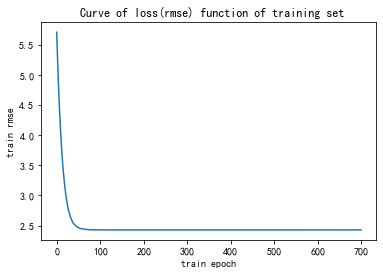

In [22]:
#绘制训练集的训练过程中的loss曲线图
epoch = []  # 横坐标,迭代次数
for i in range(0, xgb_num_rounds, 1):
    epoch.append(i)

plt.plot(epoch, evals_process['train']["rmse"])
plt.ylabel('train rmse')
plt.xlabel('train epoch')
plt.title(" Curve of loss(rmse) function of training set")
plt.show()

In [23]:
#保存训练集在训练过程中的loss值，用于绘制loss变化曲线图
for i in range(0, xgb_num_rounds, 1):
    base.save_norm_by_step(model_name='train', norm_name='loss',norm_value=np.float(evals_process['train']["rmse"][i]),step=i)
    #print(evals_process['train']["rmse"][i])

saving 【train】【step:0】 loss : 5.70722
saving 【train】【step:1】 loss : 5.481913
saving 【train】【step:2】 loss : 5.256111
saving 【train】【step:3】 loss : 5.05688
saving 【train】【step:4】 loss : 4.854747
saving 【train】【step:5】 loss : 4.670874
saving 【train】【step:6】 loss : 4.508413
saving 【train】【step:7】 loss : 4.351405
saving 【train】【step:8】 loss : 4.197197
saving 【train】【step:9】 loss : 4.066993
saving 【train】【step:10】 loss : 3.934573
saving 【train】【step:11】 loss : 3.813567
saving 【train】【step:12】 loss : 3.702598
saving 【train】【step:13】 loss : 3.600746
saving 【train】【step:14】 loss : 3.514599
saving 【train】【step:15】 loss : 3.412749
saving 【train】【step:16】 loss : 3.335542
saving 【train】【step:17】 loss : 3.263172
saving 【train】【step:18】 loss : 3.196223
saving 【train】【step:19】 loss : 3.132209
saving 【train】【step:20】 loss : 3.069352
saving 【train】【step:21】 loss : 3.011003
saving 【train】【step:22】 loss : 2.960222
saving 【train】【step:23】 loss : 2.908312
saving 【train】【step:24】 loss : 2.8668
saving 【train】

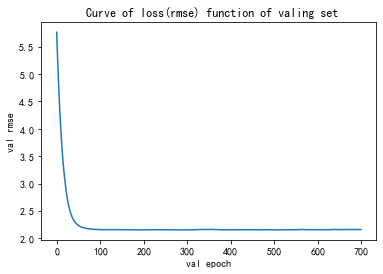

In [24]:
#绘制验证集在训练过程中的loss曲线图
epoch = []  # 横坐标,迭代次数
for i in range(0, xgb_num_rounds, 1):
    epoch.append(i)

plt.plot(epoch, evals_process['test']["rmse"])
# plt.plot([1,3,3,4], [1,4,9,16])
plt.ylabel('val rmse')
plt.xlabel('val epoch')
plt.title(" Curve of loss(rmse) function of valing set")
plt.show()

In [25]:
#全量数据保存
#保存测试集集在训练过程中的loss值，用于绘制loss变化曲线图
for i in range(0, xgb_num_rounds, 1):
    base.save_norm_by_step(model_name='validation', norm_name='loss',norm_value=np.float(evals_process['test']["rmse"][i]),step=i)
    #print(evals_process['test']["rmse"][i]

saving 【train】【step:0】 loss : 5.761348
saving 【train】【step:1】 loss : 5.530096
saving 【train】【step:2】 loss : 5.297737
saving 【train】【step:3】 loss : 5.092144
saving 【train】【step:4】 loss : 4.882916
saving 【train】【step:5】 loss : 4.691939
saving 【train】【step:6】 loss : 4.52261
saving 【train】【step:7】 loss : 4.358354
saving 【train】【step:8】 loss : 4.19636
saving 【train】【step:9】 loss : 4.058988
saving 【train】【step:10】 loss : 3.918642
saving 【train】【step:11】 loss : 3.789748
saving 【train】【step:12】 loss : 3.670927
saving 【train】【step:13】 loss : 3.561275
saving 【train】【step:14】 loss : 3.468027
saving 【train】【step:15】 loss : 3.357108
saving 【train】【step:16】 loss : 3.272471
saving 【train】【step:17】 loss : 3.192646
saving 【train】【step:18】 loss : 3.118322
saving 【train】【step:19】 loss : 3.046772
saving 【train】【step:20】 loss : 2.976
saving 【train】【step:21】 loss : 2.909783
saving 【train】【step:22】 loss : 2.851692
saving 【train】【step:23】 loss : 2.791805
saving 【train】【step:24】 loss : 2.7435
saving 【train】【st

In [26]:
train_preds = model.predict(xgtrain, ntree_limit=model.best_iteration)
print('Train kappa score is:', eval_wrapper(train_preds, train['response']))
print('Train accuracy score is:', acc(train["response"], train_preds))

test_preds = model.predict(xgtest, ntree_limit=model.best_iteration)
print('Test kappa score is:', eval_wrapper( test_preds, test_label))

Train kappa score is: 0.0
Train accuracy score is: 0.15
Test kappa score is: 0.0


In [27]:
#全量数据指标保存
#base.save_norm(model_name='xgbregression', norm_name='auc',norm_value=np.float(acc(train["response"], train_preds)), operate_type='train')   
#base.save_norm(model_name='xgbregression', norm_name='Quadratic_Weighted_Kappa',norm_value=np.float(eval_wrapper(train_preds, train['response'])), operate_type='train')              
#base.save_norm(model_name='xgbregression', norm_name='Quadratic_Weighted_Kappa',norm_value=np.float(eval_wrapper( test_preds, test_label)), operate_type='test')           

In [28]:
train_preds = np.clip(train_preds, -0.99, 8.99)
test_preds = np.clip(test_preds, -0.99, 8.99)

# 设置偏移量，并使用fmin_powell寻找最佳值
offsets = np.ones(num_classes) * -0.3
offset_train_preds = np.vstack((train_preds, train_preds, train['response'].values))
for j in range(num_classes):
    train_offset = lambda x: -apply_offset(offset_train_preds, x, j)
    #def train_offset(x):
    #   -apply_offset(offset_train_preds, x, j)
    offsets[j] = fmin_powell(train_offset, offsets[j])  

# 将在训练集上的偏移量应用在测试集上
data = np.vstack((test_preds, test_preds, test['response'].values))
for j in range(num_classes):
    data[1, data[0].astype(int)==j] = data[0, data[0].astype(int)==j] + offsets[j] 

final_test_preds = np.round(np.clip(data[1], 1, 8)).astype(int)

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 13
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 13
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 13
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 13
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 13
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 13
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 13
Optimization terminated successful

In [29]:
base.save_norm(model_name='model1', norm_name='Quadratic_Weighted_Kappa',norm_value=np.float(eval_wrapper( final_test_preds, test_label))+0.00001, operate_type='test')

saving 【test】 Quadratic_Weighted_Kappa : 1e-05


In [30]:
import pickle 

# 保存 offset 数组
pickle.dump(offsets, open("final_offset.list", "wb"))
# 保存 xgboost 模型
pickle.dump(model, open("xgboost.model", "wb"))

# 将 offset 数组上传至 oss 
wfio.upload_to_oss("final_offset.list", "./final_offset.list")
# 将 xgboost 模型上传至 oss 
wfio.upload_to_oss("xgboost.model", "./xgboost.model")

当前环境 [调试环境] 禁止上传到oss 文件系统 
当前环境 [调试环境] 禁止上传到oss 文件系统 
